# Model Output Analysis

```bash
# create "finalized_model_{ts}.sav" within the model folder
python3 train_model data model

# do this 9 more times
for i in {1..9}; do python3 train_model.py data model; done
```

In [1]:
import os
import csv
import json
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import joblib
import xgboost
from sklearn.metrics import plot_confusion_matrix, f1_score
from tqdm import tqdm_notebook

from util.evaluate_12ECG_score import load_table, load_weights
from train_12ECG_classifier import _get_fieldnames

In [2]:
# Load the SNOMED_CT Mapping to DX
with open("data/snomed_ct_dx_map.json", "r") as f:
    SNOMED_CODE_MAP = json.load(f)

# Load the scored labels and weights
rows, _cols, _vals = load_table("evaluation-2020/weights.csv")
scored_codes = [int(r) for r in rows]


In [3]:
# output_folder = "mrr_model"
output_folder = "mean_model" # best, submission
# output_folder = "paper_models" # generated importances

In [4]:
with open(os.path.join(output_folder, "features.csv"), "r") as f:
    reader = csv.reader(f)
    header = next(reader)

# load the cached ECG record features
data_cache_fp = os.path.join(output_folder, "features.csv")
data_cache = pd.read_csv(data_cache_fp, header=0, names=header, index_col="header_file")

# convert the structured array into unstructured arrays
# to_features = [n for n in data_cache.dtype.names if n not in ("dx", "record_name", "seq_len")]
# with open("model/features.csv", "r") as f:
#     reader = csv.DictReader(f, fieldnames=_get_fieldnames())
#     header = next(reader)


In [5]:
label_cache = {}
with open(os.path.join(output_folder, "dxs.txt"), mode="r", newline="\n") as labelfile:
    for line in labelfile.readlines():
        header_file_path, dxs = json.loads(line)
        label_cache[header_file_path] = dxs

- complete right bundle branch block (code 713427006), covered by right bundle branch block (code 59118001)
- premature atrial contraction (code 284470004), covered by supraventricular premature beats (code 63593006)
- premature ventricular contractions (code 427172004), covered by ventricular ectopic beats (code 17338001)


In [6]:
# what features are we using?
for idx, field_name in enumerate(header[1:]):
    print(f"f{idx:<3}: {field_name}")

f0  : III_ECG_Rate_Mean
f1  : III_HRV_CVNN
f2  : III_HRV_CVSD
f3  : III_HRV_IQRNN
f4  : III_HRV_MedianNN
f5  : III_HRV_S
f6  : III_HRV_SD1d
f7  : III_HRV_SD2d
f8  : III_HRV_TINN
f9  : III_hb__absolute_sum_of_changes
f10 : III_hb__binned_entropy__max_bins_10
f11 : III_hb__c3__lag_1
f12 : III_hb__c3__lag_2
f13 : III_hb__c3__lag_3
f14 : III_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.2__ql_0.0
f15 : III_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.0
f16 : III_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.0
f17 : III_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.0
f18 : III_hb__cid_ce__normalize_False
f19 : III_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_2
f20 : III_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_3
f21 : III_hb__fft_coefficient__attr_"abs"__coeff_15
f22 : III_hb__fft_coefficient__attr_"abs"__coeff_6
f23 : III_hb__fft_coefficient__attr_"abs"__coeff_7
f24 : III_hb__fft_coefficient__attr_"angle"__

# Experiment Specific Outputs

In [7]:
# load the experiment save files

# Using only "dx" value (weight=1.0)
experiment_fps = tuple(sorted(glob(os.path.join(output_folder, "finalized_model_*.sav"))))

print(experiment_fps)

print(len(experiment_fps))
# no label rebalancing
# original: finalized_model_1594761951.sav to finalized_model_1594766304.sav, or first 100

('mean_model/finalized_model_1597987440.sav', 'mean_model/finalized_model_1597987570.sav', 'mean_model/finalized_model_1597987698.sav', 'mean_model/finalized_model_1597987827.sav', 'mean_model/finalized_model_1597987957.sav', 'mean_model/finalized_model_1597988084.sav', 'mean_model/finalized_model_1597988214.sav', 'mean_model/finalized_model_1597988341.sav', 'mean_model/finalized_model_1597988575.sav', 'mean_model/finalized_model_1597988823.sav', 'mean_model/finalized_model_1597989075.sav', 'mean_model/finalized_model_1597989326.sav', 'mean_model/finalized_model_1597989537.sav', 'mean_model/finalized_model_1597989656.sav', 'mean_model/finalized_model_1597989783.sav', 'mean_model/finalized_model_1597989905.sav', 'mean_model/finalized_model_1597990031.sav', 'mean_model/finalized_model_1597990154.sav', 'mean_model/finalized_model_1597990280.sav', 'mean_model/finalized_model_1597990403.sav', 'mean_model/finalized_model_1597990528.sav', 'mean_model/finalized_model_1597990654.sav', 'mean_mod

# Challenge Relevant Scores
Show the challenge reported scores on the evaluation set

In [8]:
challenge_summary_outputs = {}

# with tqdm_notebook(experiment_fps) as t:
for experiment_fp in experiment_fps:
    print(f"{experiment_fp} results...")
    experiment = joblib.load(experiment_fp)

    for k in ['auroc', 'auprc', 'accuracy', 'f_measure', 
          'f_beta_measure', 'g_beta_measure', 'challenge_metric']:
        cso = challenge_summary_outputs.get(k, [])
        cso.append(experiment[k])
        challenge_summary_outputs[k] = cso


mean_model/finalized_model_1597987440.sav results...
mean_model/finalized_model_1597987570.sav results...
mean_model/finalized_model_1597987698.sav results...
mean_model/finalized_model_1597987827.sav results...
mean_model/finalized_model_1597987957.sav results...
mean_model/finalized_model_1597988084.sav results...
mean_model/finalized_model_1597988214.sav results...
mean_model/finalized_model_1597988341.sav results...
mean_model/finalized_model_1597988575.sav results...
mean_model/finalized_model_1597988823.sav results...
mean_model/finalized_model_1597989075.sav results...
mean_model/finalized_model_1597989326.sav results...
mean_model/finalized_model_1597989537.sav results...
mean_model/finalized_model_1597989656.sav results...
mean_model/finalized_model_1597989783.sav results...
mean_model/finalized_model_1597989905.sav results...
mean_model/finalized_model_1597990031.sav results...
mean_model/finalized_model_1597990154.sav results...
mean_model/finalized_model_1597990280.sav resu

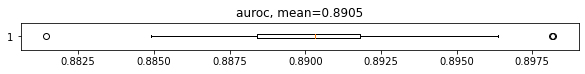

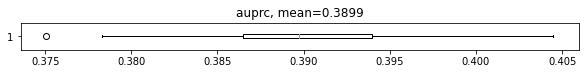

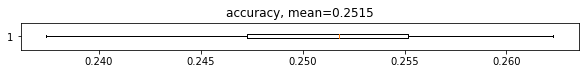

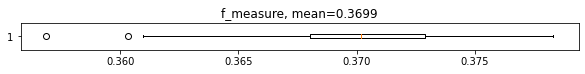

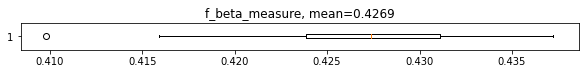

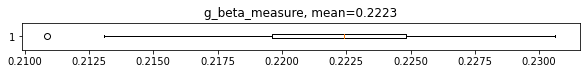

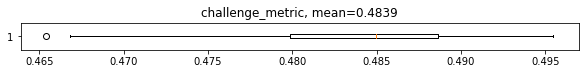

auroc
	DescribeResult(nobs=100, minmax=(0.8814334674425744, 0.8981932689041181), mean=0.8904934893663292, variance=8.290314226748222e-06, skewness=0.24137308516826217, kurtosis=0.6942187691197601)
auprc
	DescribeResult(nobs=100, minmax=(0.3750449494884354, 0.40448191991106014), mean=0.38993530441950186, variance=3.0384520813507524e-05, skewness=-0.08631331966528506, kurtosis=-0.11006972204706278)
accuracy
	DescribeResult(nobs=100, minmax=(0.237395607794618, 0.26229508196721313), mean=0.251481596040829, variance=2.8023285114626545e-05, skewness=-0.18519754385895248, kurtosis=-0.5342911064097704)
f_measure
	DescribeResult(nobs=100, minmax=(0.3568477122207015, 0.37832881454965045), mean=0.3699391046879286, variance=1.7686162929411106e-05, skewness=-0.46838447881331324, kurtosis=0.18497223192210654)
f_beta_measure
	DescribeResult(nobs=100, minmax=(0.409794598341568, 0.43723018482410564), mean=0.4269450929322874, variance=2.7480185873866813e-05, skewness=-0.4337360127981944, kurtosis=0.1066

In [9]:
all_desc_stats = {}
for k, v in challenge_summary_outputs.items():
    fig1, ax1 = plt.subplots(figsize=(10, 0.5))
    desc_stats = sp.stats.describe(v)
    all_desc_stats[k] = desc_stats
    ax1.set_title(f"{k}, mean={desc_stats.mean:.4f}")
    ax1.boxplot(v, vert=False)
    plt.show()

for k, v in all_desc_stats.items():
    print(f"{k}\n\t{v}")

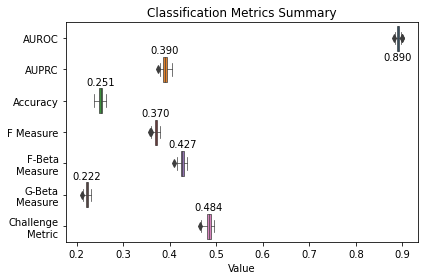

In [10]:
# print(challenge_summary_outputs)
box_plot_dict = {"Metric": [], "Value": []}
for k, v in challenge_summary_outputs.items():
    if k == "auroc":
        k_disp = "AUROC"
    elif k == "auprc":
        k_disp = "AUPRC"
    elif k == "accuracy":
        k_disp = "Accuracy"
    elif k == "f_measure":
        k_disp = "F Measure"
    elif k == "f_beta_measure":
        k_disp = "F-Beta\nMeasure"
    elif k == "g_beta_measure":
        k_disp = "G-Beta\nMeasure"
    elif k == "challenge_metric":
        k_disp = "Challenge\nMetric"
    box_plot_dict["Metric"] += [k_disp, ] * len(v)
    box_plot_dict["Value"] += v

bp_df = pd.DataFrame(box_plot_dict)
ax = sns.boxplot(
    y="Metric", x="Value", data=bp_df, linewidth=0.7
)
mean = bp_df.groupby(["Metric"])["Value"].mean()

# print(medians)

# medians
metric_ref = ["AUROC", "AUPRC", "Accuracy", "F Measure", "F-Beta\nMeasure", "G-Beta\nMeasure", "Challenge\nMetric"]

for ytick in ax.get_yticklabels():
    ytick_name = ytick.get_text()
    val_output = f"{mean[ytick_name]:.3f}"
    x_offset = mean[ytick_name]
    if mean[ytick_name] > 0.5:
        ha = "center"
        x_offset -= 0
    else:
        ha = "center"
        x_offset += 0
    y_offset = metric_ref.index(ytick_name)
    if metric_ref.index(ytick_name) >= 1:
        y_offset -= 0.6
    else:
        y_offset += 0.6
    ax.annotate(
        val_output,
        xy=(mean[ytick_name], metric_ref.index(ytick_name)),
        xytext=(x_offset, y_offset),
#         arrowprops={"arrowstyle": "-"},
        horizontalalignment=ha,
        verticalalignment="center"
    )
# print(dir(ax))
ax.set_ylabel("")
ax.set_title("Classification Metrics Summary")
plt.tight_layout()

plt.savefig(os.path.join(output_folder, "classification_metrics.png"), bbox_inches="tight", dpi=300)
plt.show()


# Confusion Matrix

In [11]:
def plot_experiment_confusion_matrices(experiment_fp):
    experiment = joblib.load(experiment_fp)
    train_records = experiment.pop("train_records")
    eval_records = experiment.pop("eval_records")

    # get the evaluation records
    
    raw_dx_evals = []

#     for (record_name, dc_row) in data_cache.iterrows():
#         if record_name in eval_records:
#             raw_data_eval = dc_row.to_numpy()

#             raw_data_evals.append(raw_data_eval)
#             raw_dx_evals.append(label_cache[record_name])
#     data_evals = np.stack(raw_data_evals)

    data_evals = data_cache.loc[eval_records]
    for (record_name, dc_row) in data_evals.iterrows():
        if record_name in eval_records:
            raw_dx_evals.append(label_cache[record_name])

    for sc in scored_codes:
        _abbrv, dx = SNOMED_CODE_MAP[str(sc)]
        
        # hardcoded duplicate classifiers based on label scoring weights
        dsc = None
        if sc == 713427006:
            # A: 713427006 and 59118001
            dsc = 59118001
        elif sc == 284470004:
            # B: 284470004 and 63593006
            dsc = 63593006
        elif sc == 427172004:
            # C: 427172004 and 17338001
            dsc = 17338001

        if dsc is not None:
            _, ddx = SNOMED_CODE_MAP[str(dsc)]
            print(f"Skipping {dx} (code {sc}), covered by {ddx} (code {dsc})")
            continue

        print(f"Classifier evaluation results for {dx} (code {sc})...")

        isc = None
        if sc == 59118001:
            isc = 713427006
        elif sc == 63593006:
            isc = 284470004
        elif sc == 17338001:
            isc = 427172004
        
        if isc is not None:
            _, idx = SNOMED_CODE_MAP[str(isc)]
            print(f"\tIncluding {idx} (code {isc})")

        eval_labels = []
        for raw_dx_eval in raw_dx_evals:
            pos = (sc in raw_dx_eval) or (isc is not None and isc in raw_dx_eval)
            eval_labels.append(pos)
        
        try:
            model = experiment[str(sc)]
        except KeyError:
            model = experiment[int(sc)]
        xgb_params = model.get_xgb_params()
        disp_params = {**xgb_params, 'monotone_constraints': None}
        print(disp_params)
        # print(f"scale_pos_weight: {xgb_params['scale_pos_weight']:.4f}")

        #fig, axs = plt.subplots(nrows=1, ncols=2)
        fig = plt.figure(constrained_layout=True, figsize=(14, 4))
        fig.suptitle(dx, x=0, y=1, horizontalalignment="left", fontsize=20)
        gs = fig.add_gridspec(1, 3)
        ax0 = fig.add_subplot(gs[0, 0])
        ax0.set_title("Evaluation")
        ax1 = fig.add_subplot(gs[0, 1:])
        
        # normalize must be one of {'true', 'pred', 'all', None}
        disp = plot_confusion_matrix(
            model, data_evals, eval_labels, normalize=None, ax=ax0,
        )
        # https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.plot_importance
        importance_type = "weight" # weight, gain, cover
        importance_title = f"Feature Importance by {importance_type}"
        ax = xgboost.plot_importance(
            model, height=0.2, max_num_features=15, ax=ax1,
            title=importance_title, importance_type=importance_type)
        plt.show()


In [12]:
# plot_experiment_confusion_matrices(experiment_fps[1])
# plot_experiment_confusion_matrices(experiment_fps[1])  # so on...

# F1-Scores across all experiments

In [14]:

f1_box_plot_data = {}

for experiment_fp in experiment_fps:
    print(f"{experiment_fp} results...")
    experiment = joblib.load(experiment_fp)
    train_records = experiment.pop("train_records")
    eval_records = experiment.pop("eval_records")
    
    raw_dx_evals = []

    data_evals = data_cache.loc[eval_records]
    for (record_name, dc_row) in data_evals.iterrows():
        if record_name in eval_records:
            raw_dx_evals.append(label_cache[record_name])

    for sc in scored_codes:
        abbrv, dx = SNOMED_CODE_MAP[str(sc)]

#         # hardcoded duplicate classifiers based on label scoring weights
#         dsc = None
#         if sc == 713427006:
#             # A: 713427006 and 59118001
#             dsc = 59118001
#         elif sc == 284470004:
#             # B: 284470004 and 63593006
#             dsc = 63593006
#         elif sc == 427172004:
#             # C: 427172004 and 17338001
#             dsc = 17338001

#         if dsc is not None:
#             #_, ddx = SNOMED_CODE_MAP[str(dsc)]
#             #print(f"Skipping {dx} (code {sc}), covered by {ddx} (code {dsc})")
#             continue

        isc = None
#         if sc == 59118001:
#             isc = 713427006
#         elif sc == 63593006:
#             isc = 284470004
#         elif sc == 17338001:
#             isc = 427172004
        
#         if isc is not None:
#             _, idx = SNOMED_CODE_MAP[str(isc)]

        eval_labels = []
        for raw_dx_eval in raw_dx_evals:
            pos = (sc in raw_dx_eval) or (isc is not None and isc in raw_dx_eval)
            eval_labels.append(pos)
        
        try:
            model = experiment[str(sc)]
        except KeyError:
            model = experiment[int(sc)]

        # normalize must be one of {'true', 'pred', 'all', None}
        pred = model.predict(data_evals)
        f1 = f1_score(eval_labels, pred)
        # print(f"\t{dx} ({abbrv}) (code {sc}) F1_Score:", f1)

        f1_box_plot_data[abbrv] = f1_box_plot_data.get(abbrv, []) + [f1,]



mean_model/finalized_model_1597987440.sav results...
mean_model/finalized_model_1597987570.sav results...
mean_model/finalized_model_1597987698.sav results...
mean_model/finalized_model_1597987827.sav results...
mean_model/finalized_model_1597987957.sav results...
mean_model/finalized_model_1597988084.sav results...
mean_model/finalized_model_1597988214.sav results...
mean_model/finalized_model_1597988341.sav results...
mean_model/finalized_model_1597988575.sav results...
mean_model/finalized_model_1597988823.sav results...
mean_model/finalized_model_1597989075.sav results...
mean_model/finalized_model_1597989326.sav results...
mean_model/finalized_model_1597989537.sav results...
mean_model/finalized_model_1597989656.sav results...
mean_model/finalized_model_1597989783.sav results...
mean_model/finalized_model_1597989905.sav results...
mean_model/finalized_model_1597990031.sav results...
mean_model/finalized_model_1597990154.sav results...
mean_model/finalized_model_1597990280.sav resu

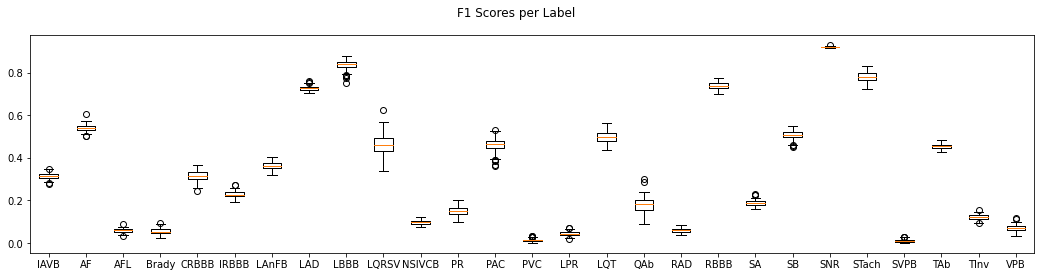

In [15]:
# construct and display the boxplot
x_ticks = []
bp_data = []
for k, v in f1_box_plot_data.items():
    bp_data.append(v)
    x_ticks.append(k)

fig, ax = plt.subplots(figsize=(18, 4))
fig.suptitle("F1 Scores per Label")
ax.boxplot(bp_data)
ax.set_xticklabels(x_ticks)
plt.show()

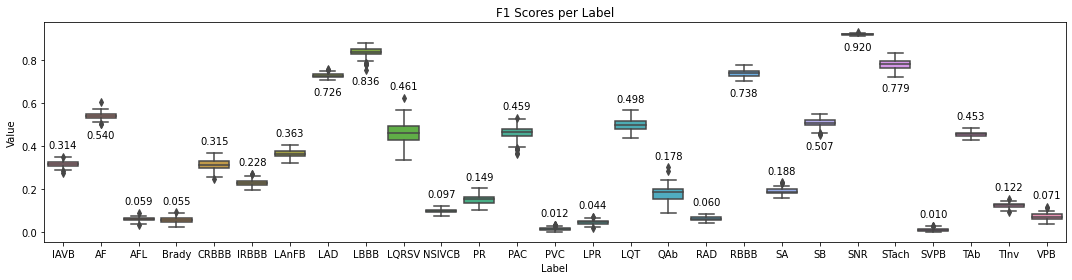

In [22]:
# construct and display the boxplot
box_plot_dict = {"Label": [], "Value": []}
mean_dict = {}
for k, v in f1_box_plot_data.items():
    box_plot_dict["Label"] += [k,] * len(v)
    box_plot_dict["Value"] += v
    mean_dict[k] = np.mean(v)

bp_df = pd.DataFrame(box_plot_dict)
fig, ax = plt.subplots(figsize=(15, 4))
ax = sns.boxplot(x="Label", y="Value", data=bp_df, ax=ax)

# print(mean_dict)

for label_idx, xtick in enumerate(ax.get_xticklabels()):
    xtick_name = xtick.get_text()
    val_output = f"{mean_dict[xtick_name]:.3f}"
    y_offset = mean_dict[xtick_name]
    
    if y_offset >= 0.5:
        y_offset = min(f1_box_plot_data[xtick_name]) - 0.03
        va="top"
    else:
        y_offset = max(f1_box_plot_data[xtick_name]) + 0.03
        va="bottom"
    
    ax.annotate(
        val_output,
        xy=(label_idx, mean_dict[xtick_name]),
        xytext=(label_idx, y_offset),
        horizontalalignment="center",
        verticalalignment=va
    )

ax.set_title("F1 Scores per Label")
plt.tight_layout()

plt.savefig(os.path.join(output_folder, "label_f1s.png"), bbox_inches="tight", dpi=300)
plt.show()

# Feature Importance Per Label

For each label, roughly what are the most important features?

In [17]:

feat_importance_data = {}

for experiment_fp in experiment_fps:
    print(f"{experiment_fp} results...")
    experiment = joblib.load(experiment_fp)
    train_records = experiment.pop("train_records")
    eval_records = experiment.pop("eval_records")

    for sc in scored_codes:
        abbrv, dx = SNOMED_CODE_MAP[str(sc)]
        
        try:
            model = experiment[str(sc)]
        except KeyError:
            model = experiment[int(sc)]
        
        feat_importance_data[abbrv] = feat_importance_data.get(abbrv, []) + [model.feature_importances_]


mean_model/finalized_model_1597987440.sav results...
mean_model/finalized_model_1597987570.sav results...
mean_model/finalized_model_1597987698.sav results...
mean_model/finalized_model_1597987827.sav results...
mean_model/finalized_model_1597987957.sav results...
mean_model/finalized_model_1597988084.sav results...
mean_model/finalized_model_1597988214.sav results...
mean_model/finalized_model_1597988341.sav results...
mean_model/finalized_model_1597988575.sav results...
mean_model/finalized_model_1597988823.sav results...
mean_model/finalized_model_1597989075.sav results...
mean_model/finalized_model_1597989326.sav results...
mean_model/finalized_model_1597989537.sav results...
mean_model/finalized_model_1597989656.sav results...
mean_model/finalized_model_1597989783.sav results...
mean_model/finalized_model_1597989905.sav results...
mean_model/finalized_model_1597990031.sav results...
mean_model/finalized_model_1597990154.sav results...
mean_model/finalized_model_1597990280.sav resu

In [18]:
# average all of the importances for all classifiers and all labels?
all_importances = []
for label, v in feat_importance_data.items():
    ft_data = np.stack(v)
    all_importances.append(ft_data)

importances = np.concatenate(all_importances, axis=0)

print("importances.shape", importances.shape)
mean_importances = np.mean(importances, axis=0)

all_importances_rank = importances.argsort(axis=1)
importances_reciprocal_rank = 1 / (all_importances_rank + 1)
rank_importances = np.mean(importances_reciprocal_rank, axis=0)


import json
importance_data = {}
importance_data["rank_importances"] = dict(zip(header[1:], rank_importances.tolist()))
importance_data["rank_sorted_keys"] = sorted(importance_data["rank_importances"].keys(), key=lambda x:importance_data["rank_importances"][x], reverse=True)
importance_data["mean_importances"] = dict(zip(header[1:], mean_importances.tolist()))
importance_data["sorted_keys"] = sorted(importance_data["mean_importances"].keys(), key=lambda x:importance_data["mean_importances"][x], reverse=True)

with open(os.path.join(output_folder, "importances_rank.json"), "w") as f:
    json.dump(importance_data, f)


importances.shape (2700, 1000)


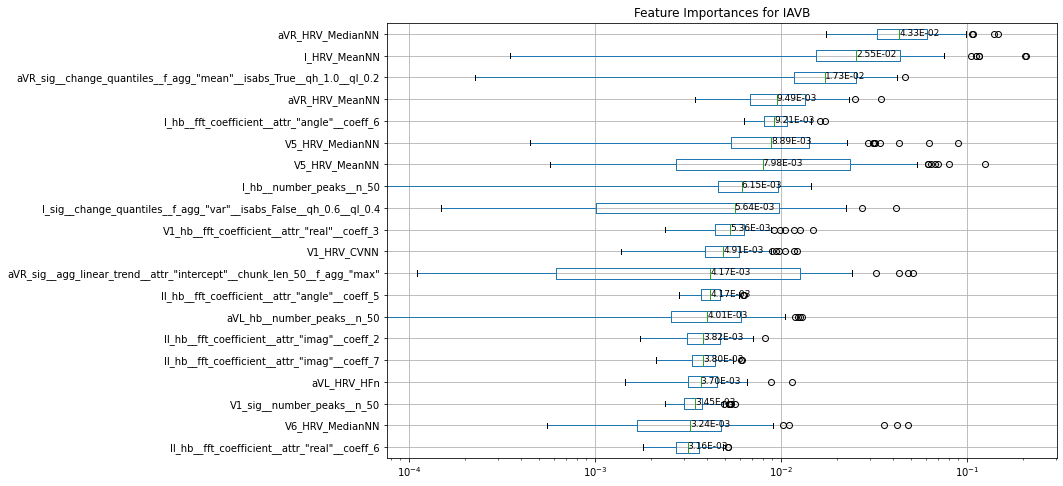

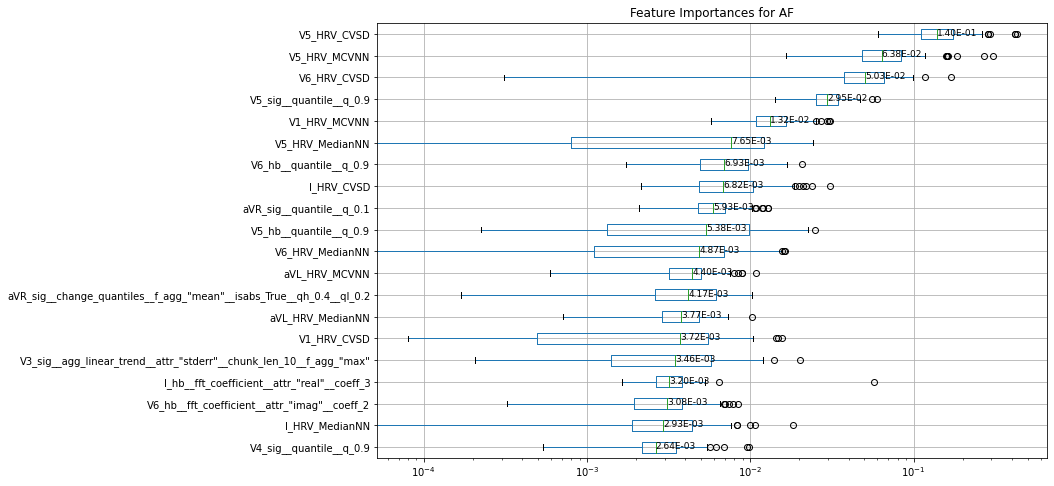

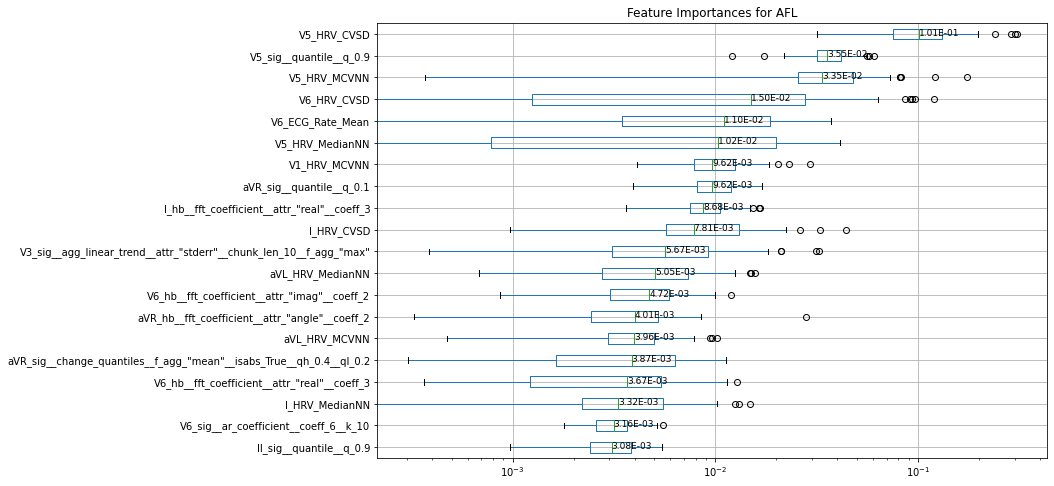

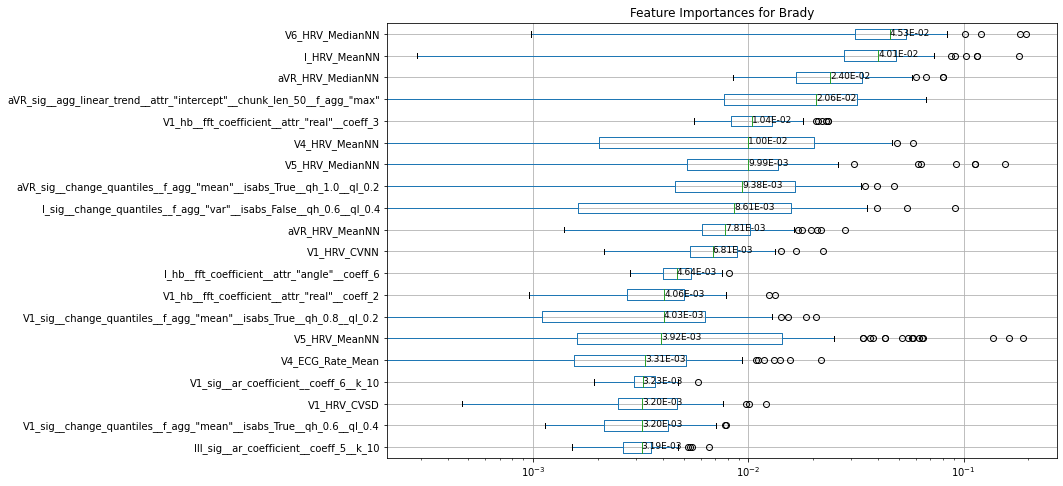

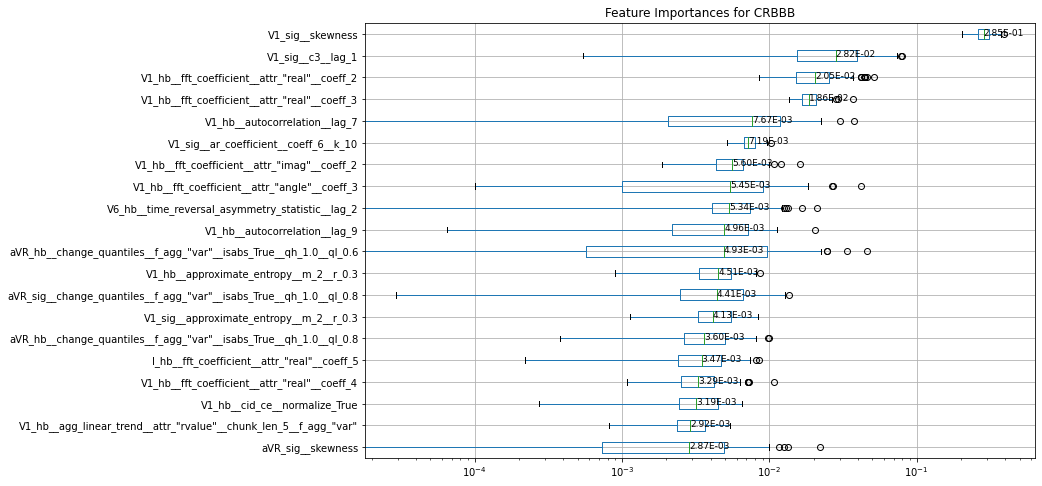

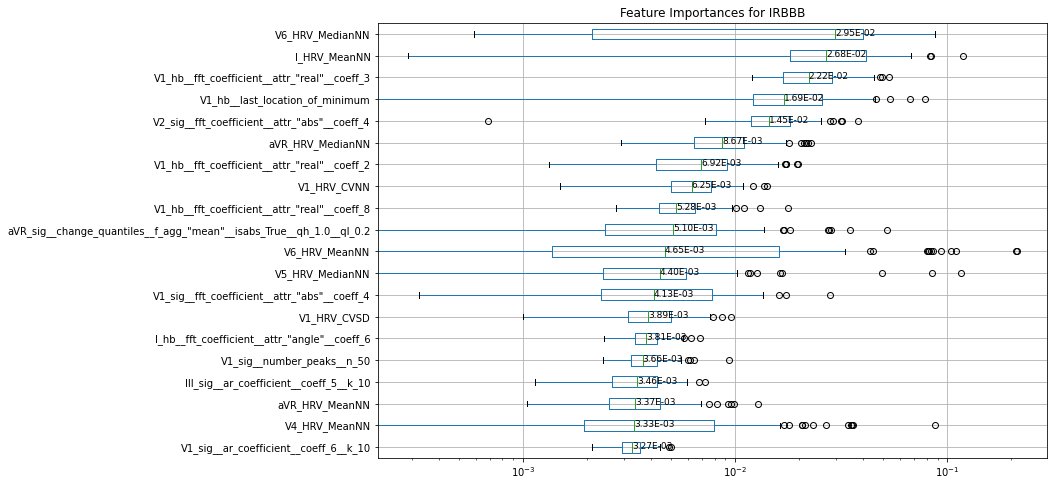

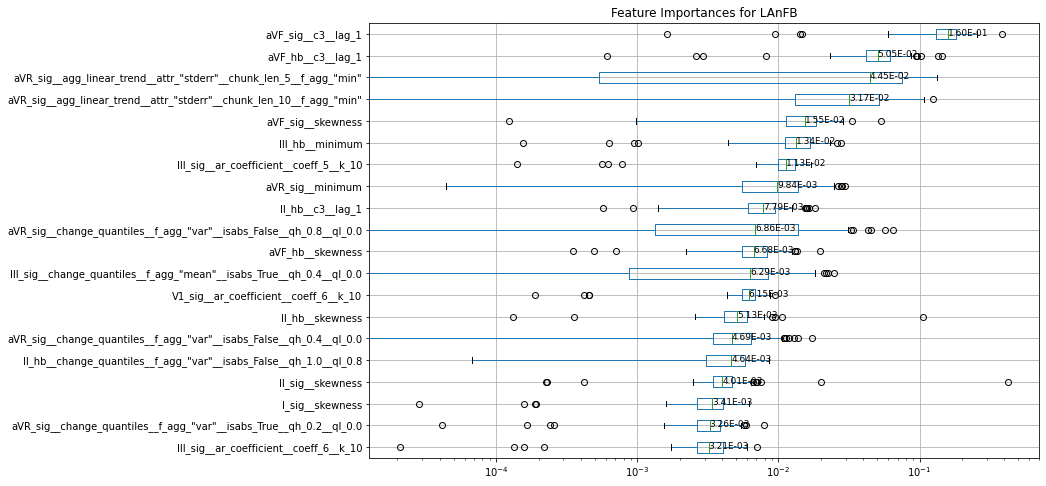

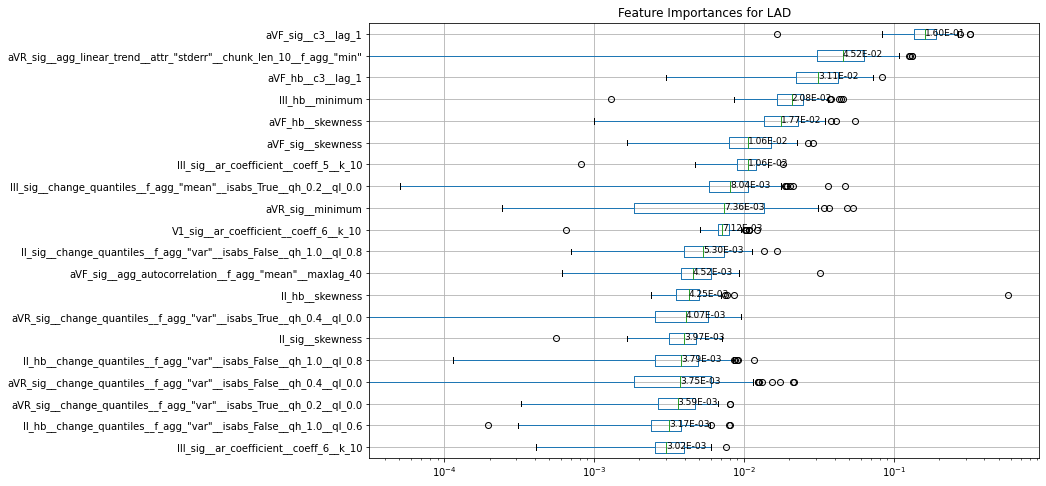

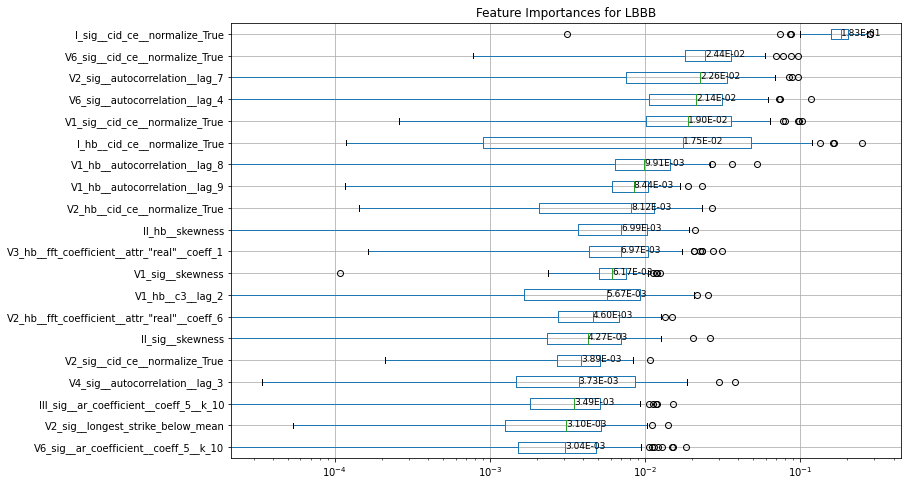

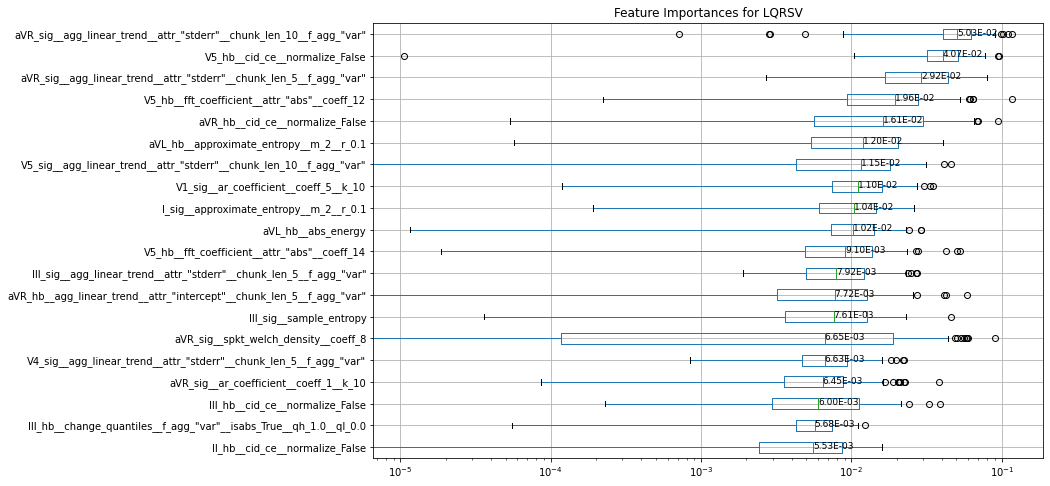

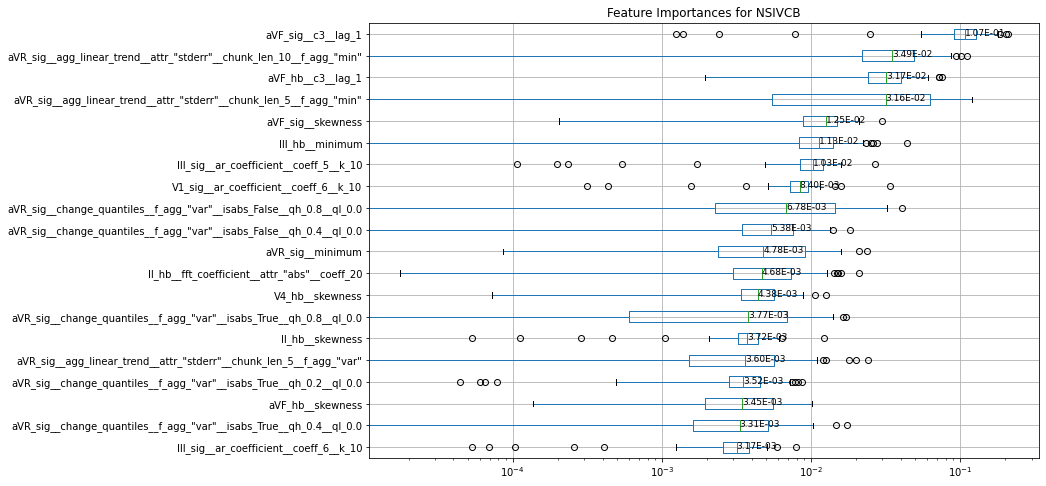

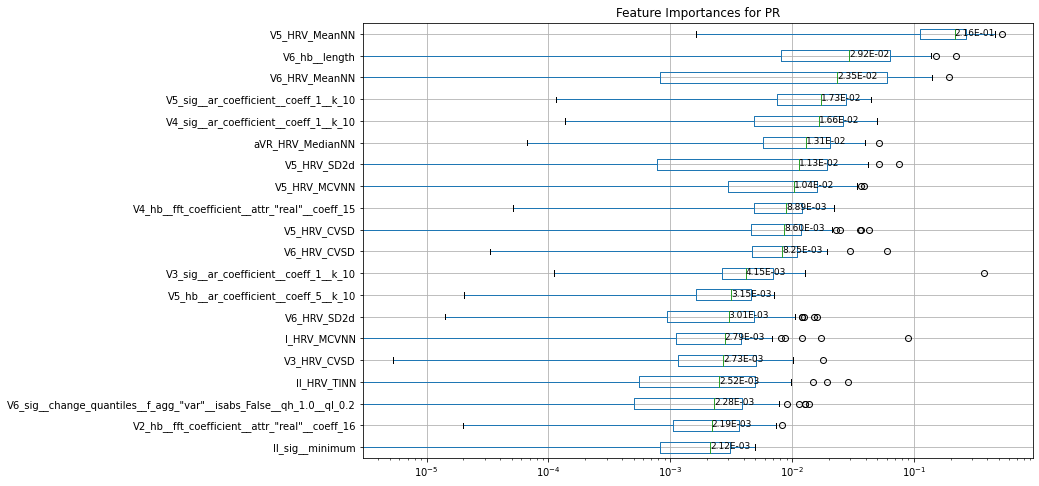

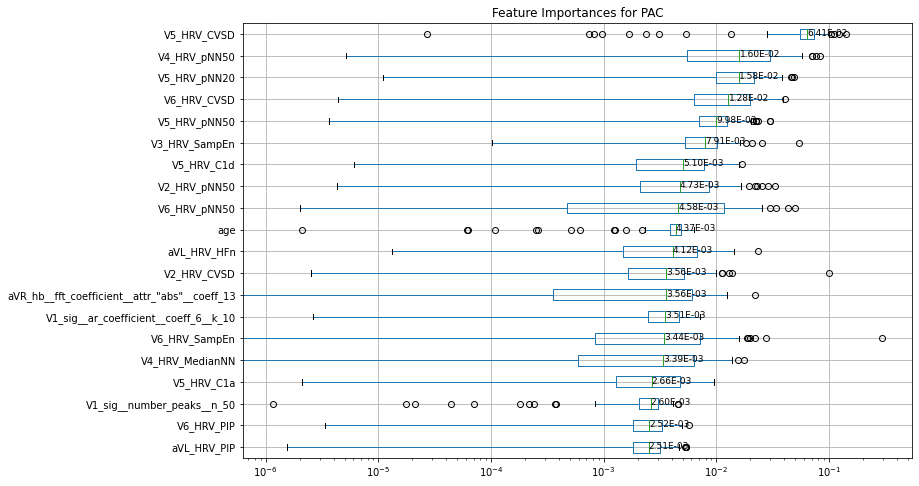

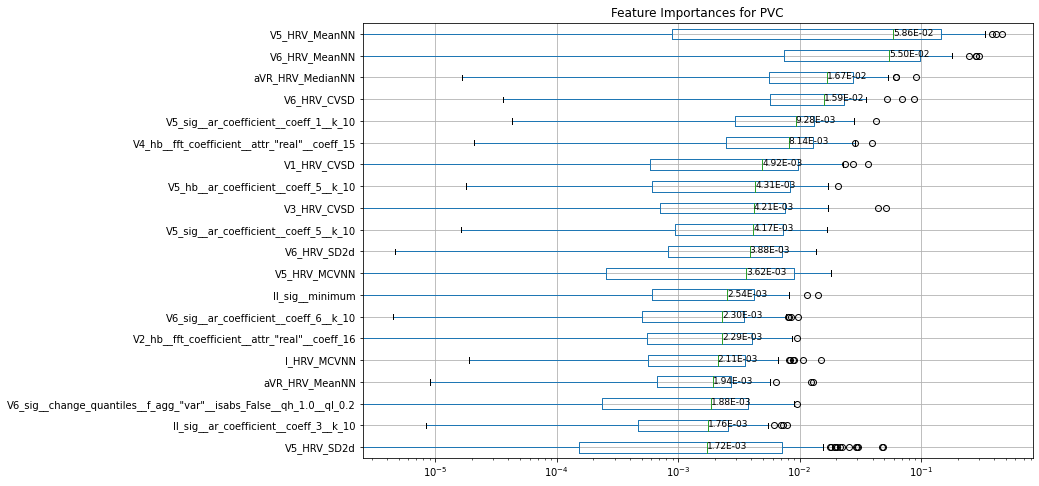

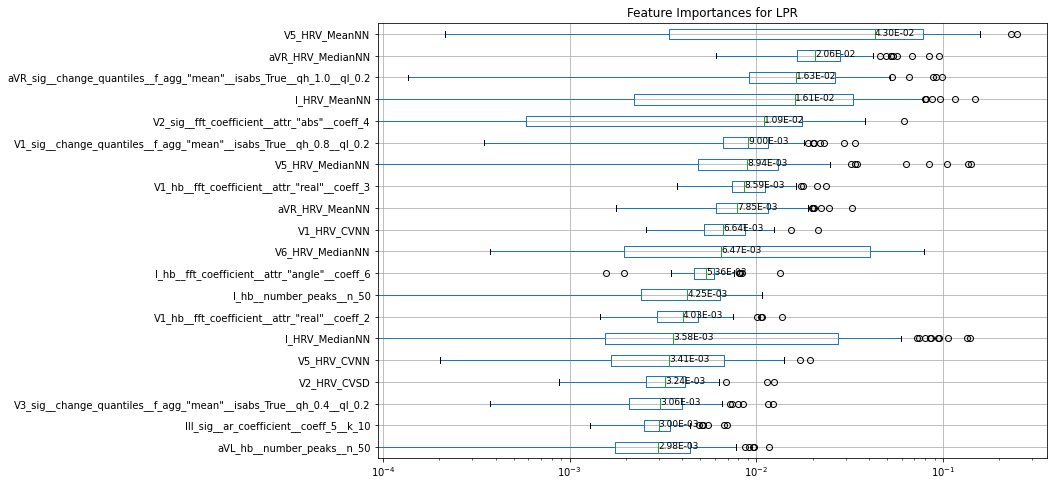

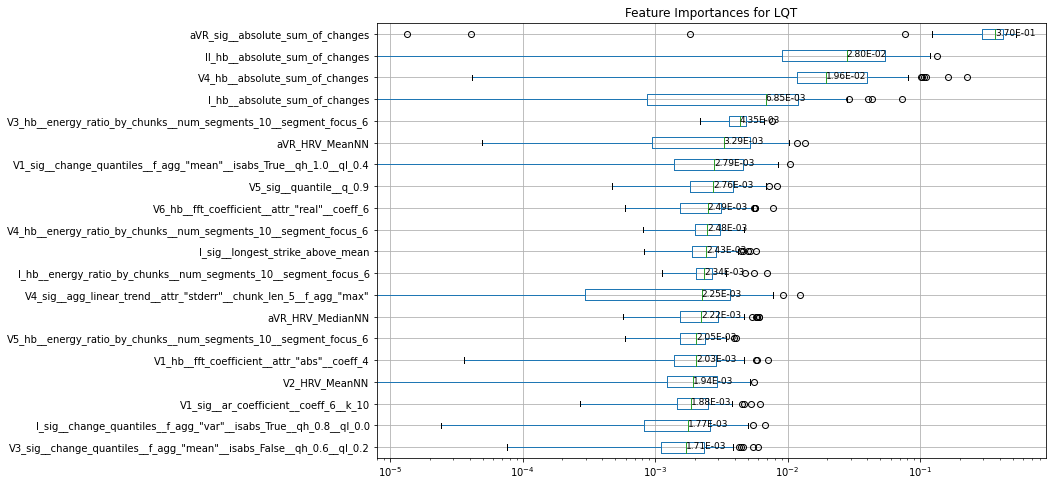

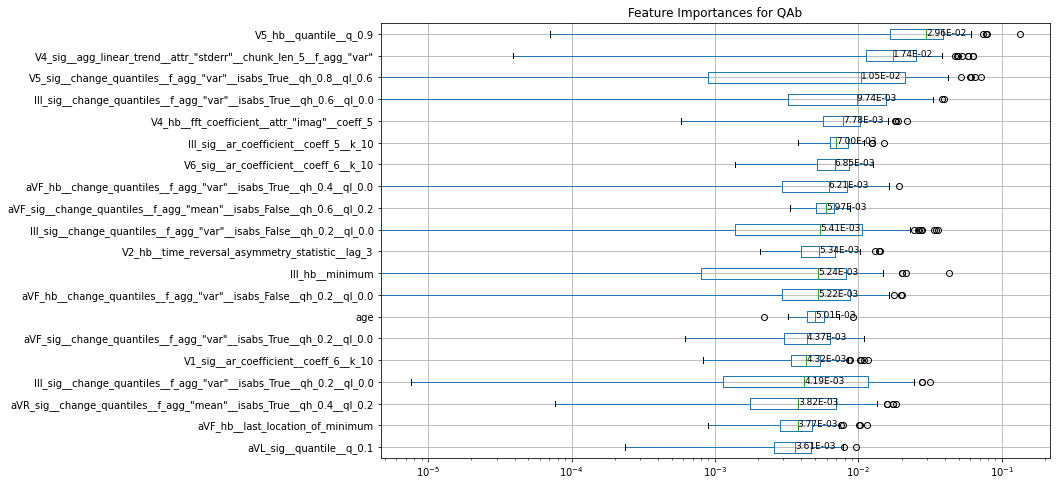

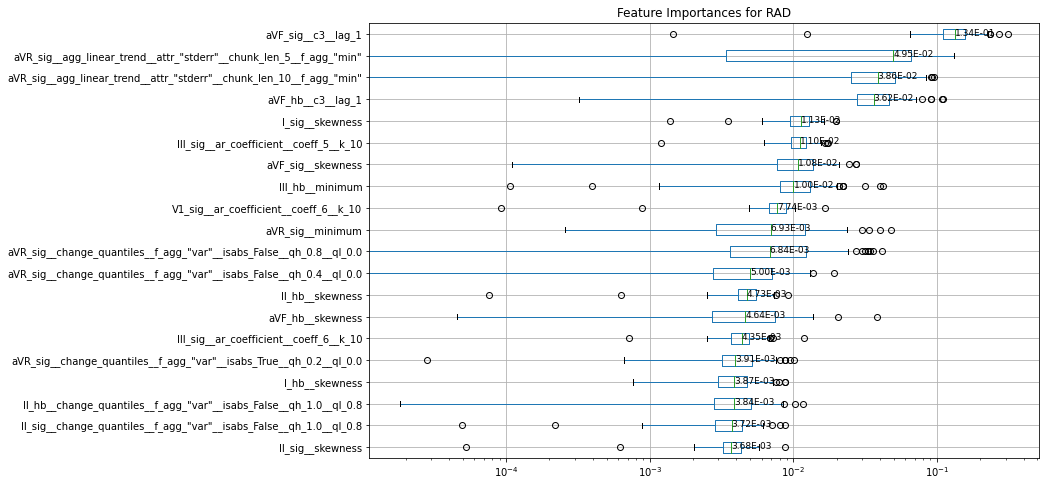

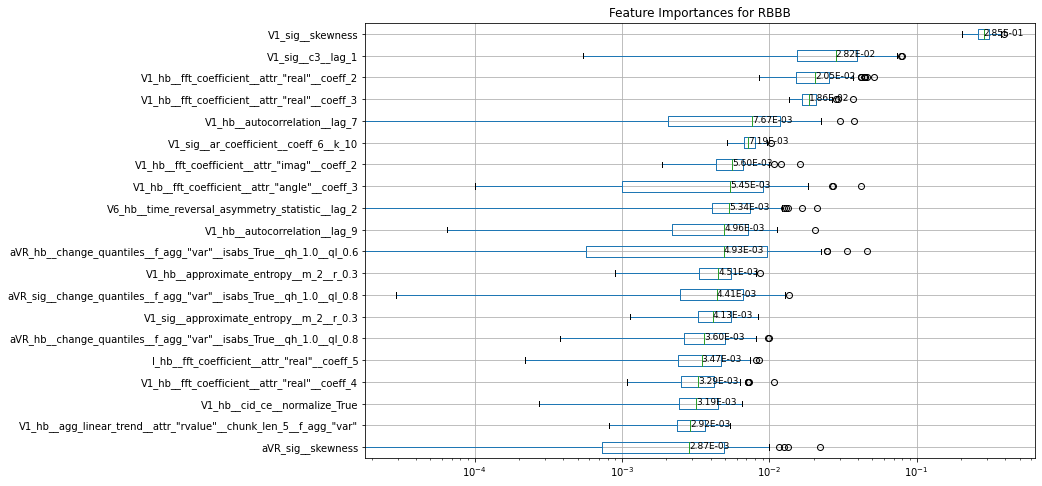

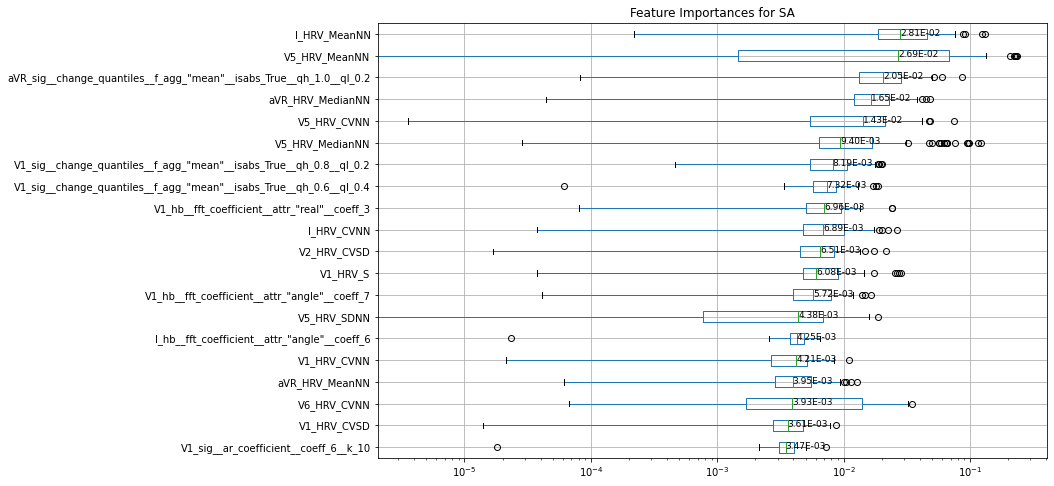

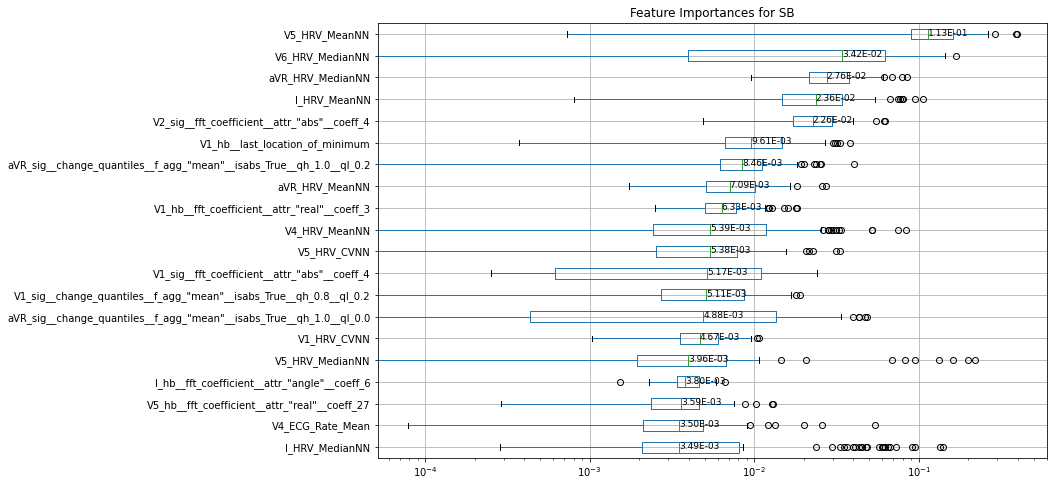

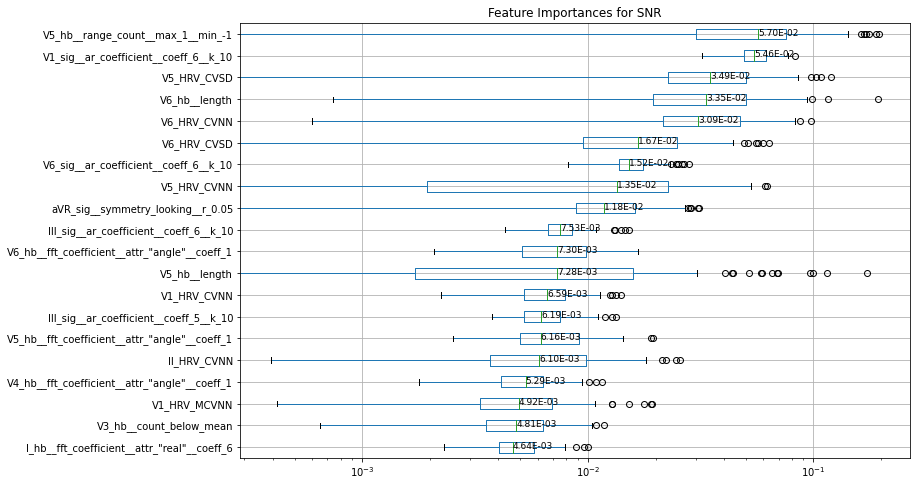

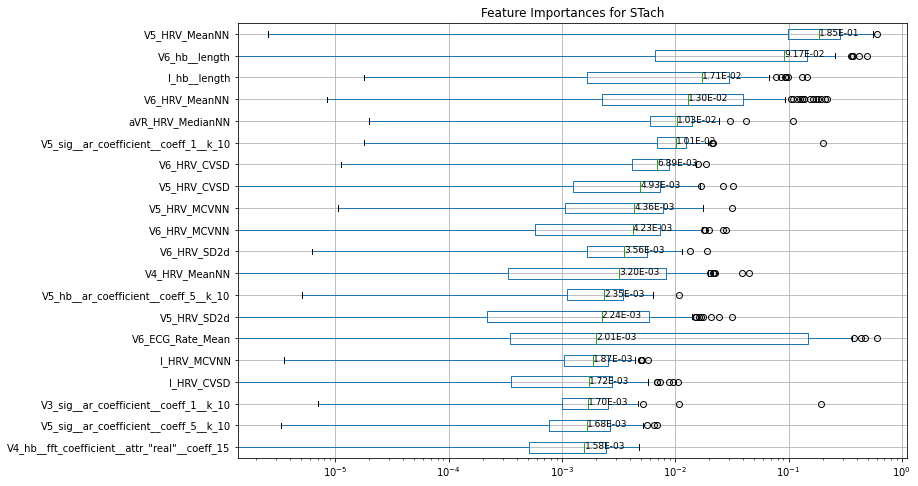

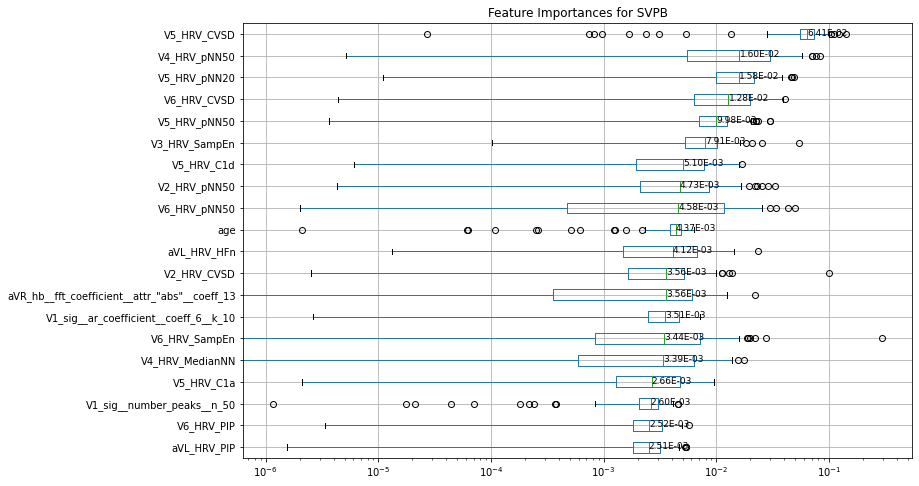

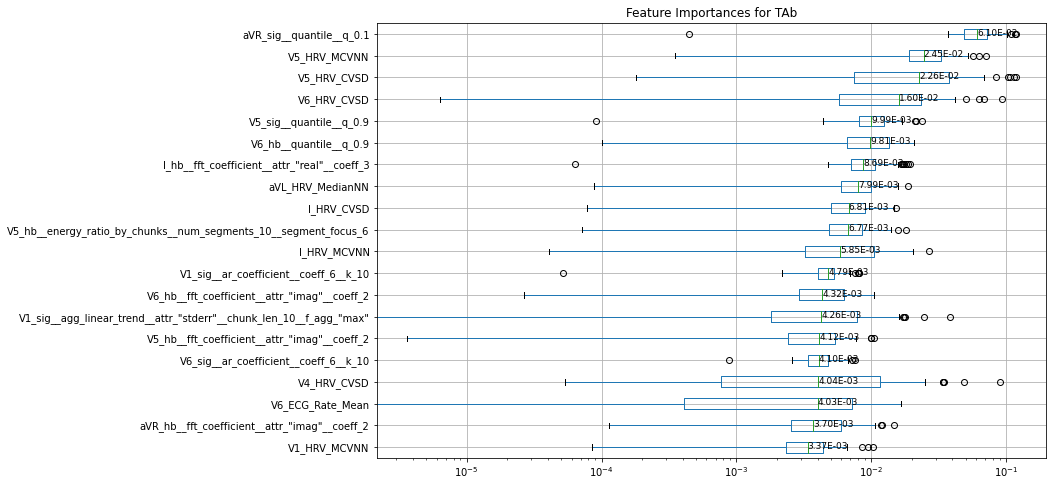

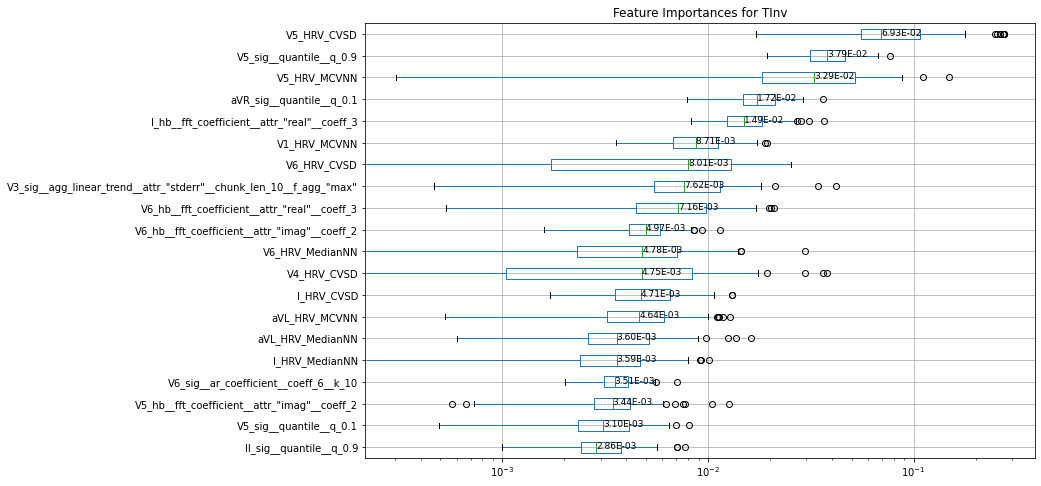

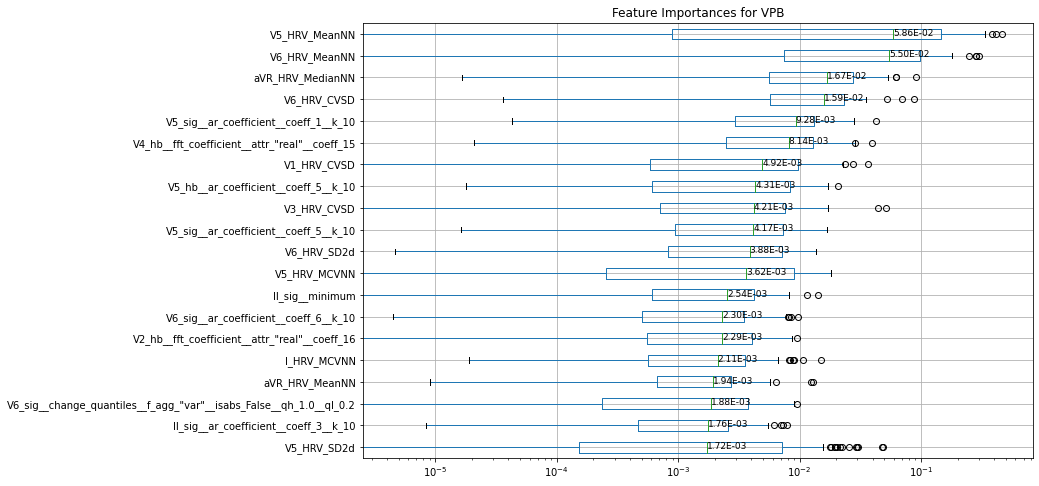

In [19]:
for k, v in feat_importance_data.items():    
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_title(f"Feature Importances for {k}")

    ft_data = np.stack(v)
    
    ft_df = pd.DataFrame(data=ft_data, columns=header[1:])

    meds = ft_df.median()
    meds.sort_values(ascending=True, inplace=True)
    
    meds = meds.tail(20)
    
    ft_df = ft_df[meds.index]
        
    result = ft_df.boxplot(vert=False, ax=ax, return_type="dict")

    for line in result["medians"]:
        x, y = line.get_xydata()[1] # top of the median line
        ax.text(x, y, "%.2E" % x, fontsize=9, horizontalalignment="left", verticalalignment="top")
    
    ax.set_xscale("log")
    
    plt.show()
    
    #ax.boxplot(ft_data, labels=to_features, vert=False)
    #ax.set_xticklabels(x_ticks)
    
    #plt.show()
    #print(np.stack(v, axis=1).shape)    

## Feature Importances

Visualize the feature importances in a figure by lead and feature type (heart rate variability, template, full waveform)?

In [20]:
lead_feat_type_counter = {}

for k, v in importance_data["mean_importances"].items():
    lead_type, *feat_args = k.split("__")
#     print(lead_type)
    lead, *feat_type = lead_type.split("_")
    
    if lead == "age":
        continue
    
    if "hb" in feat_type:
        # heart beat feat type
        feat_type = "Heartbeat\nTemplate"
    elif "sig" in feat_type:
        # full waveform feat type
        feat_type = "Full\nWaveform"
    else:
        # heart rate variability type
        feat_type = "Heart Rate\nVariability"
    
    count_dict = lead_feat_type_counter.get(feat_type, {})
    count = count_dict.get(lead, 0)
    count += 1
    count_dict[lead] = count
    lead_feat_type_counter[feat_type] = count_dict

lead_feat_type_df = pd.DataFrame(lead_feat_type_counter)
lead_feat_type_df = lead_feat_type_df.reindex(["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"])
lead_feat_type_df = lead_feat_type_df.reindex(["Full\nWaveform", "Heartbeat\nTemplate", "Heart Rate\nVariability"], axis=1)
lead_feat_type_df

,Full\nWaveform,Heartbeat\nTemplate,Heart Rate\nVariability
I,24,61,15
II,27,58,13
III,19,24,9
aVR,55,92,12
aVL,13,18,15
aVF,23,26,10
V1,55,82,13
V2,15,24,12
V3,15,27,13
V4,20,38,18


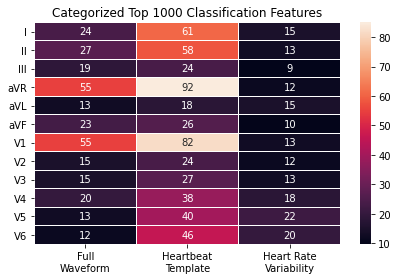

In [21]:
ax = sns.heatmap(
    lead_feat_type_df,
    annot=True,
    linewidths= 0.2,
    robust=True
)
ax.set_title("Categorized Top 1000 Classification Features")
plt.tight_layout()

plt.savefig(os.path.join(output_folder, "top_features.png"), bbox_inches="tight", dpi=300)
plt.show()

# Challenge Evaluation Summary Outputs

In [23]:
mean_dict
dxms = pd.read_csv("evaluation-2020/dx_mapping_scored.csv")
dxms

,Dx,SNOMED CT Code,Abbreviation,CPSC,CPSC-Extra,StPetersburg,PTB,PTB-XL,Georgia,Total,Notes
0,1st degree av block,270492004,IAVB,722,106,0,0,797,769,2394,NaN
1,atrial fibrillation,164889003,AF,1221,153,2,15,1514,570,3475,NaN
2,atrial flutter,164890007,AFL,0,54,0,1,73,186,314,NaN
3,bradycardia,426627000,Brady,0,271,11,0,0,6,288,NaN
4,complete right bundle branch block,713427006,CRBBB,0,113,0,0,542,28,683,We score 713427006 and 59118001 as the same di...
5,incomplete right bundle branch block,713426002,IRBBB,0,86,0,0,1118,407,1611,NaN
6,left anterior fascicular block,445118002,LAnFB,0,0,0,0,1626,180,1806,NaN
7,left axis deviation,39732003,LAD,0,0,0,0,5146,940,6086,NaN
8,left bundle branch block,164909002,LBBB,236,38,0,0,536,231,1041,NaN
9,low qrs voltages,251146004,LQRSV,0,0,0,0,182,374,556,NaN


In [24]:
# quick pearson r stat test
totals = {}
a = []
b = []
for k, v in mean_dict.items():
    if k == "VEB":
        k = "VPB"
    t = dxms[dxms["Abbreviation"] == k]["Total"].to_numpy()[0]
#     ratio = t / 43101
#     print(t, ratio)
    totals[k] = t
    a.append(v)
    b.append(t)

# print(a)
# print(b)
print(sp.stats.pearsonr(a, b))

(0.5987761738469429, 0.0009676915536949795)


In [25]:
print("neg_cor", sp.stats.pearsonr(range(10), range(10, 0, -1)))
print("pos_cor", sp.stats.pearsonr(range(10), range(0,10, 1)))
print("no_cor", sp.stats.pearsonr(range(10), [4, 5,] * 5))


neg_cor (-1.0, 0.0)
pos_cor (1.0, 0.0)
no_cor (0.17407765595569788, 0.630536075556976)


In [22]:
# for k in ['auroc', 'auprc', 'accuracy', 'f_measure', 
#           'f_beta_measure', 'g_beta_measure', 'challenge_metric']:
#     print(f"{model_data[k]:>10.3f}")

    
# print("AUROC | AUPRC | Accuracy | F-measure | Fbeta-measure | Gbeta-measure | Challenge metric")
# print(f"{model_data['auroc']:>5.3f} |"
#       f" {model_data['auprc']:>5.3f} |"
#       f" {model_data['accuracy']:>8.3f} |"
#       f" {model_data['f_measure']:>9.3f} |"
#       f" {model_data['f_beta_measure']:>13.3f} |"
#       f" {model_data['g_beta_measure']:>13.3f} |"
#       f" {model_data['challenge_metric']:>16.3f}")


## MED-ARC Training Times

- on 96 parallel cores, used approximately 220 GiB RAM
- each process requires ~2.3GiB of RAM
- takes roughly ~80 seconds to process one record (at 96 parallel cores, one record can be extracted per second)

- classifier training, takes approximately 60-65GiB (sequential classifier training)
    - experiment with parallel classifier training using separate GPU per label
    - GPU RAM usage relatively low (2900MiB), but 100% GPU utilization

In [23]:
43101 / 60 / 60

11.9725

In [24]:
(43101 /2 * 80) / 60 / 60

478.9

In [25]:
(18950 - 2 - (12 * 53)) / 12 / 2


763.0

In [45]:
flights = sns.load_dataset("flights")
flights = flights.pivot("month", "year", "passengers")
flights

year,1949,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960
month,,,,,,,,,,,,
January,112,115,145,171,196,204,242,284,315,340,360,417
February,118,126,150,180,196,188,233,277,301,318,342,391
March,132,141,178,193,236,235,267,317,356,362,406,419
April,129,135,163,181,235,227,269,313,348,348,396,461
May,121,125,172,183,229,234,270,318,355,363,420,472
June,135,149,178,218,243,264,315,374,422,435,472,535
July,148,170,199,230,264,302,364,413,465,491,548,622
August,148,170,199,242,272,293,347,405,467,505,559,606
September,136,158,184,209,237,259,312,355,404,404,463,508
